In [ ]:
!pip install imagesize
!pip install pickle5
!pip install imgaug==0.2.6
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 133kB 12.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218609 sha256=3e92c9255a3ac5a1ca0ba21347638c618494a9e1bfbaa6b5313dbf728ddb978a
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 634kB 18.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=f1b80f2f28495ca995b47d76abb7ba4484d27e82619a463b2d3d107c6f3a157f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 276kB 22.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=9b9faf284e3d1d816648f635630732a19b2

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import pickle5
import imagesize
import pprint
import json
import random
from IPython.display import display
from tqdm.notebook import tqdm
from itertools import groupby
from pycocotools import mask as maskutil
from pycocotools.coco import COCO

plt.style.use('seaborn')

import torch
import torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.structures import BoxMode

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/My Drive/AI 人工智慧/基於深度學習之視覺辨識專論/HW3'
os.chdir(root)
trainPath = 'train_images'
testPath = 'test_images'
maskTrainJSON = 'pascal_train.json'
testJSON = 'test.json'
datasetPath = 'dataset.pkl'

def Imshow(img):
    if len(img.shape) == 3:
        img = img[:, :, ::-1]

    plt.imshow(img)


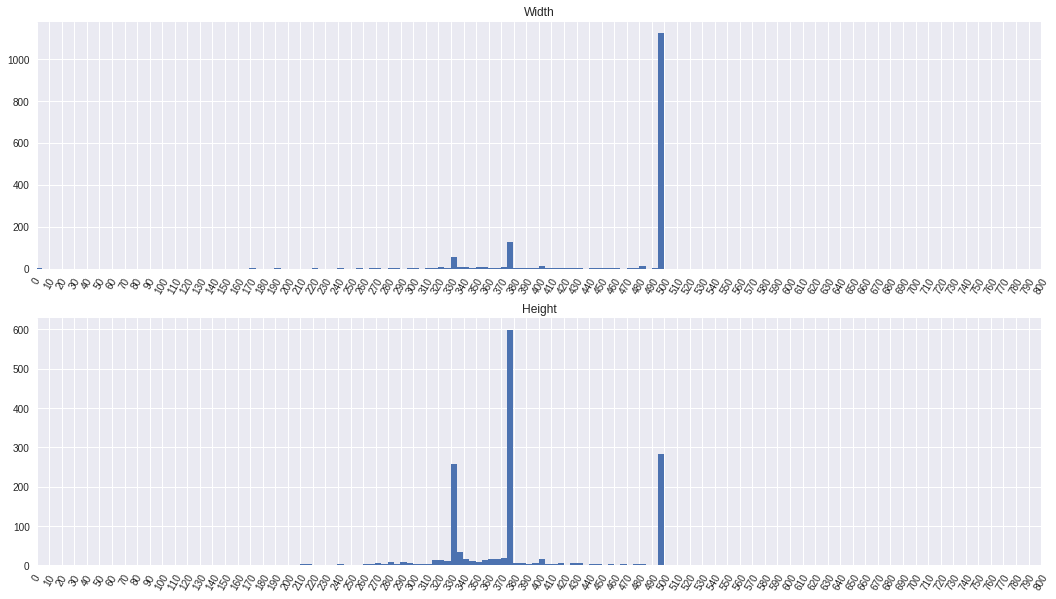

In [ ]:
def PlotImageSizeHist(dirs):
    widths = []
    heights = []
    for dir in dirs:
        paths = glob.glob(os.path.join(dir, '*'))
        for path in paths:
            try:
                width, height = imagesize.get(path)
                widths.append(width)
                heights.append(height)
            except:
                print(f"Odd file: [{path}].")
    
    plt.figure(figsize=(18, 10))
    plt.subplot(211); plt.hist(widths, 100); plt.title("Width"); plt.xlim([0, 800]); plt.xticks(range(0, 801, 10), rotation=60)
    plt.subplot(212); plt.hist(heights, 100); plt.title("Height"); plt.xlim([0, 800]); plt.xticks(range(0, 801, 10), rotation=60)
    return widths, heights


widths, heights = PlotImageSizeHist([trainPath, testPath])


In [ ]:
def GetDataset(coco, dir=trainPath):
    dataset = []
    for img in coco.imgs.values():
        data = {
            'file_name': os.path.join(dir, img['file_name']),
            'height': img['height'],
            'width': img['width']
        }

        instances = []
        for ann in coco.loadAnns(coco.getAnnIds(img['id'])):
            instance = {
                'bbox': ann['bbox'],
                'bbox_mode': BoxMode.XYXY_ABS,
                'segmentation': ann['segmentation'],
                'category_id': ann['category_id'] - 1,
                'iscrowd': ann['iscrowd']
            }
            instances.append(instance)
        
        data['annotations'] = instances
        dataset.append(data)

    return dataset


def SearchData(imgName, dataset, dir=trainPath):
    for data in dataset:
        if data['file_name'] == f'{dir}/{imgName}':
            return data


coco = COCO(maskTrainJSON)


loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [ ]:
dataset = GetDataset(coco)
with open(datasetPath, 'wb') as f:
    pickle5.dump(dataset, f)
    

In [ ]:
with open(datasetPath, 'rb') as f:
    dataset = pickle5.load(f)


In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [
            T.RandomBrightness(0.6, 1.4),
            T.RandomContrast(0.6, 1.4),
            T.RandomSaturation(0.6, 1.4),
            T.RandomRotation(angle=[-60, 60]),
            T.RandomLighting(0.7)
        ]
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)


DatasetCatalog.register(trainPath, lambda: dataset)
MetadataCatalog.get(trainPath).thing_classes = [cat['supercategory'] for cat in coco.cats.values()]

metaData = MetadataCatalog.get(trainPath)


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = 'pretrained_model/imagenet_mask_rcnn_R101_FPN_3x.pth'
cfg.DATASETS.TRAIN = (trainPath,)
cfg.DATASETS.TEST = ()
cfg.INPUT.CROP.ENABLED = True
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 30000
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_FACTOR = 1./1000
cfg.SOLVER.STEPS = (1500, 5000, 10000, 15000, 20000, 25000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(coco.cats)
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = 'range'
cfg.INPUT.MAX_SIZE_TRAIN = 450
cfg.INPUT.MIN_SIZE_TRAIN = (300, 400)
cfg.INPUT.MAX_SIZE_TEST = 450
cfg.INPUT.MIN_SIZE_TEST = (300, 400)
cfg.TEST.DETECTIONS_PER_IMAGE = 100

pprint.pprint(cfg)


{'CUDNN_BENCHMARK': False,
 'DATALOADER': {'ASPECT_RATIO_GROUPING': True,
                'FILTER_EMPTY_ANNOTATIONS': True,
                'NUM_WORKERS': 1,
                'REPEAT_THRESHOLD': 0.0,
                'SAMPLER_TRAIN': 'TrainingSampler'},
 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000,
              'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000,
              'PROPOSAL_FILES_TEST': (),
              'PROPOSAL_FILES_TRAIN': (),
              'TEST': (),
              'TRAIN': ('train_images',)},
 'GLOBAL': CfgNode({'HACK': 1.0}),
 'INPUT': {'CROP': {'ENABLED': True,
                    'SIZE': [0.9, 0.9],
                    'TYPE': 'relative_range'},
           'FORMAT': 'BGR',
           'MASK_FORMAT': 'polygon',
           'MAX_SIZE_TEST': 450,
           'MAX_SIZE_TRAIN': 450,
           'MIN_SIZE_TEST': (300, 400),
           'MIN_SIZE_TRAIN': (300, 400),
           'MIN_SIZE_TRAIN_SAMPLING': 'range',
           'RANDOM_FLIP': 'horizontal'},
 'MODEL': {'ANCHOR_GENERATO

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)

[11/28 06:30:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.train()

[11/28 05:46:21 d2.engine.train_loop]: Starting training from iteration 28150


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[11/28 05:46:28 d2.utils.events]:  eta: 0:21:24  iter: 28159  total_loss: 0.2902  loss_cls: 0.04938  loss_box_reg: 0.08453  loss_mask: 0.1505  loss_rpn_cls: 0.00129  loss_rpn_loc: 0.005692  time: 0.7133  data_time: 0.3847  lr: 1.5625e-05  max_mem: 2309M
[11/28 05:46:42 d2.utils.events]:  eta: 0:20:12  iter: 28179  total_loss: 0.2873  loss_cls: 0.05494  loss_box_reg: 0.0838  loss_mask: 0.1545  loss_rpn_cls: 0.003249  loss_rpn_loc: 0.004627  time: 0.6862  data_time: 0.3154  lr: 1.5625e-05  max_mem: 2489M
[11/28 05:46:56 d2.utils.events]:  eta: 0:19:08  iter: 28199  total_loss: 0.1914  loss_cls: 0.02385  loss_box_reg: 0.03527  loss_mask: 0.1247  loss_rpn_cls: 0.0007361  loss_rpn_loc: 0.004094  time: 0.6466  data_time: 0.2777  lr: 1.5625e-05  max_mem: 2489M
[11/28 05:47:09 d2.utils.events]:  eta: 0:19:07  iter: 28219  total_loss: 0.2541  loss_cls: 0.02665  loss_box_reg: 0.06079  loss_mask: 0.1439  loss_rpn_cls: 0.0003216  loss_rpn_loc: 0.004261  time: 0.6583  data_time: 0.3349  lr: 1.5625e

In [ ]:
cfg.MODEL.WEIGHTS = "output/model_0028199.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
def Predict(predictor, img, showImage=True):
    testImg = cv2.imread(img)
    pred = predictor(testImg)
    if showImage:
        v = Visualizer(testImg[:, :, ::-1], metadata=metaData)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))

        plt.figure(figsize=(testImg.shape[0]//5, testImg.shape[1]//10))
        plt.subplot(121); plt.imshow(v.get_image())
        plt.subplot(122); plt.imshow(testImg[:, :, ::-1])
        plt.show()
    
    return pred


def GetMasks(pred):
    masks = pred['instances'].get_fields()['pred_masks'].to('cpu').numpy()
    return masks * 1


def GetBBoxes(pred):
    bboxes = pred['instances'].get_fields()['pred_boxes'].tensor.to('cpu').numpy()
    bboxes[:, [0, 1, 2, 3]] = bboxes[:, [1, 0, 3, 2]]
    return [tuple(bbox) for bbox in bboxes.tolist()]


def GetScores(pred):
    scores = pred['instances'].get_fields()['scores'].to('cpu').numpy()
    return scores.tolist()


def GetLabels(pred):
    labels = pred['instances'].get_fields()['pred_classes'].to('cpu').numpy()
    return labels.tolist()


def GetTestImgData(testJSON=testJSON):
    with open(testJSON, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    
    return dataset


def GetTestImgID(img, dataset):
    for data in dataset['images']:
        if data['file_name'] == img: return data['id']
    
    raise Exception(f"No corresponding image ID for {img} !")


def BinaryMaskToRLE(binaryMask):
    rle = {'counts': [], 'size': list(binaryMask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binaryMask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)

        counts.append(len(list(elements)))

    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle


def DumpResultsToJSON(predictor, dir=testPath, testJSON=testJSON, save=True, jsonName='309612092.json'):
    testImgs = glob.glob(os.path.join(dir, '*.jpg'))
    dataset = GetTestImgData(testJSON)
    results = []
    print(f"Start predicting all images in [{dir}]...")
    for testImg in tqdm(testImgs):
        pred = Predict(predictor, testImg, False)
        labels = GetLabels(pred)
        scores = GetScores(pred)
        masks = GetMasks(pred)
        imgID = GetTestImgID(os.path.split(testImg)[-1], dataset)
        num = len(labels)
        for i in range(num):
            result = {
                'image_id': imgID,
                'category_id': labels[i] + 1,
                'segmentation': BinaryMaskToRLE(masks[i]),
                'score': scores[i]
            }
            results.append(result)
    
    if save:
        print(f"Dumping the JSON file: [{jsonName}] ...")
        with open(jsonName, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False)
    
    print("Done!")
    return results


def ShowPredictImages(predictor, num, dir=testPath):
    imgs = glob.glob(os.path.join(dir, '*.jpg'))
    imgsChosen = random.sample(imgs, num)
    for img in imgsChosen:
        print('='*100)
        print(f'[{img}]: \n')
        Predict(predictor, img)
        print('\n')



[test_images/2007_001733.jpg]: 



/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


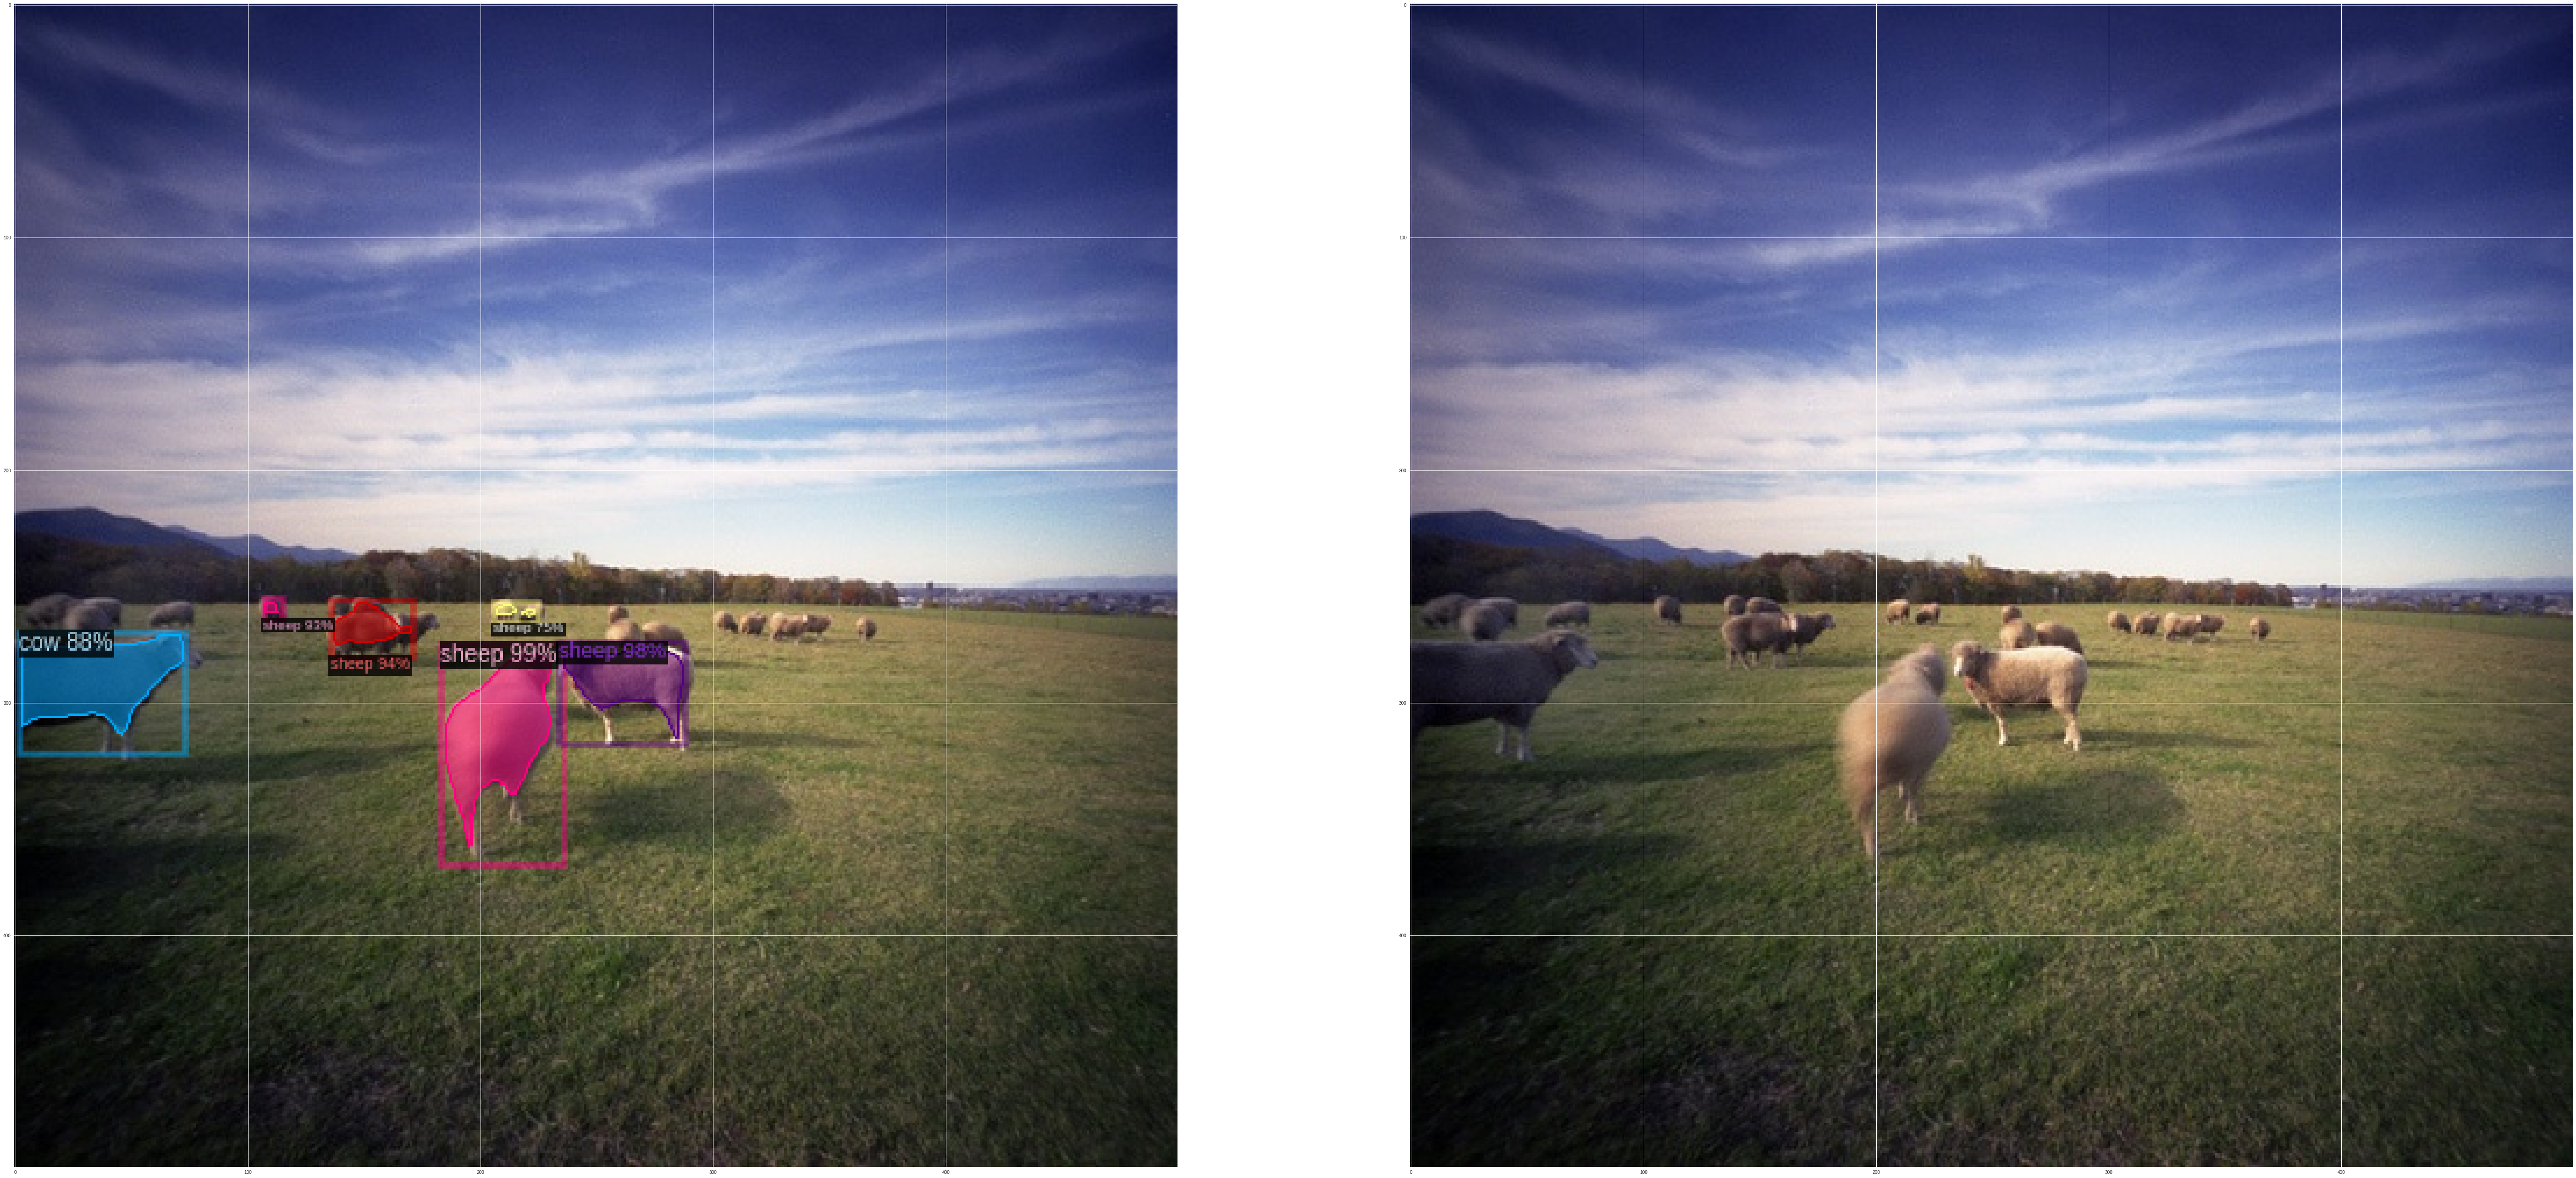



[test_images/2011_002322.jpg]: 



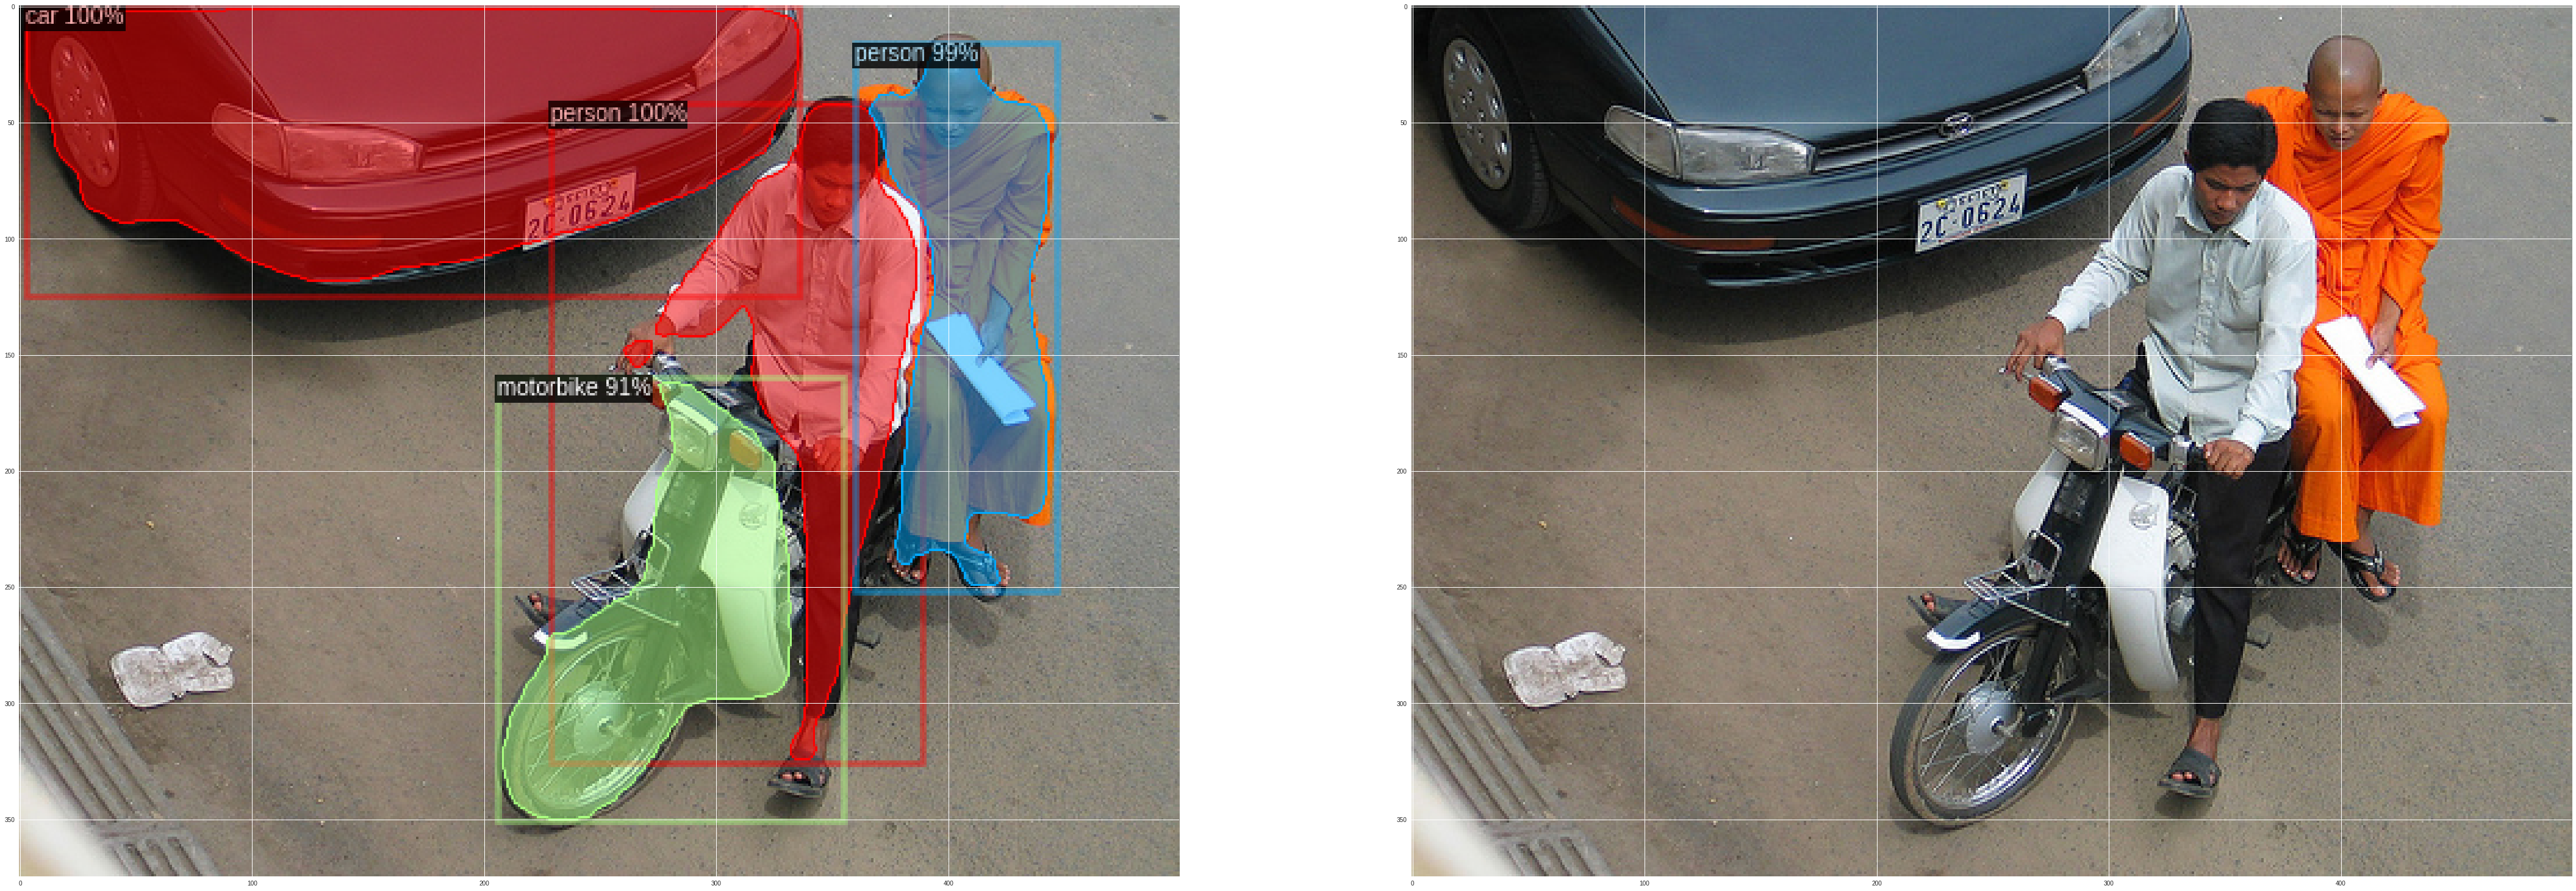



[test_images/2008_006143.jpg]: 



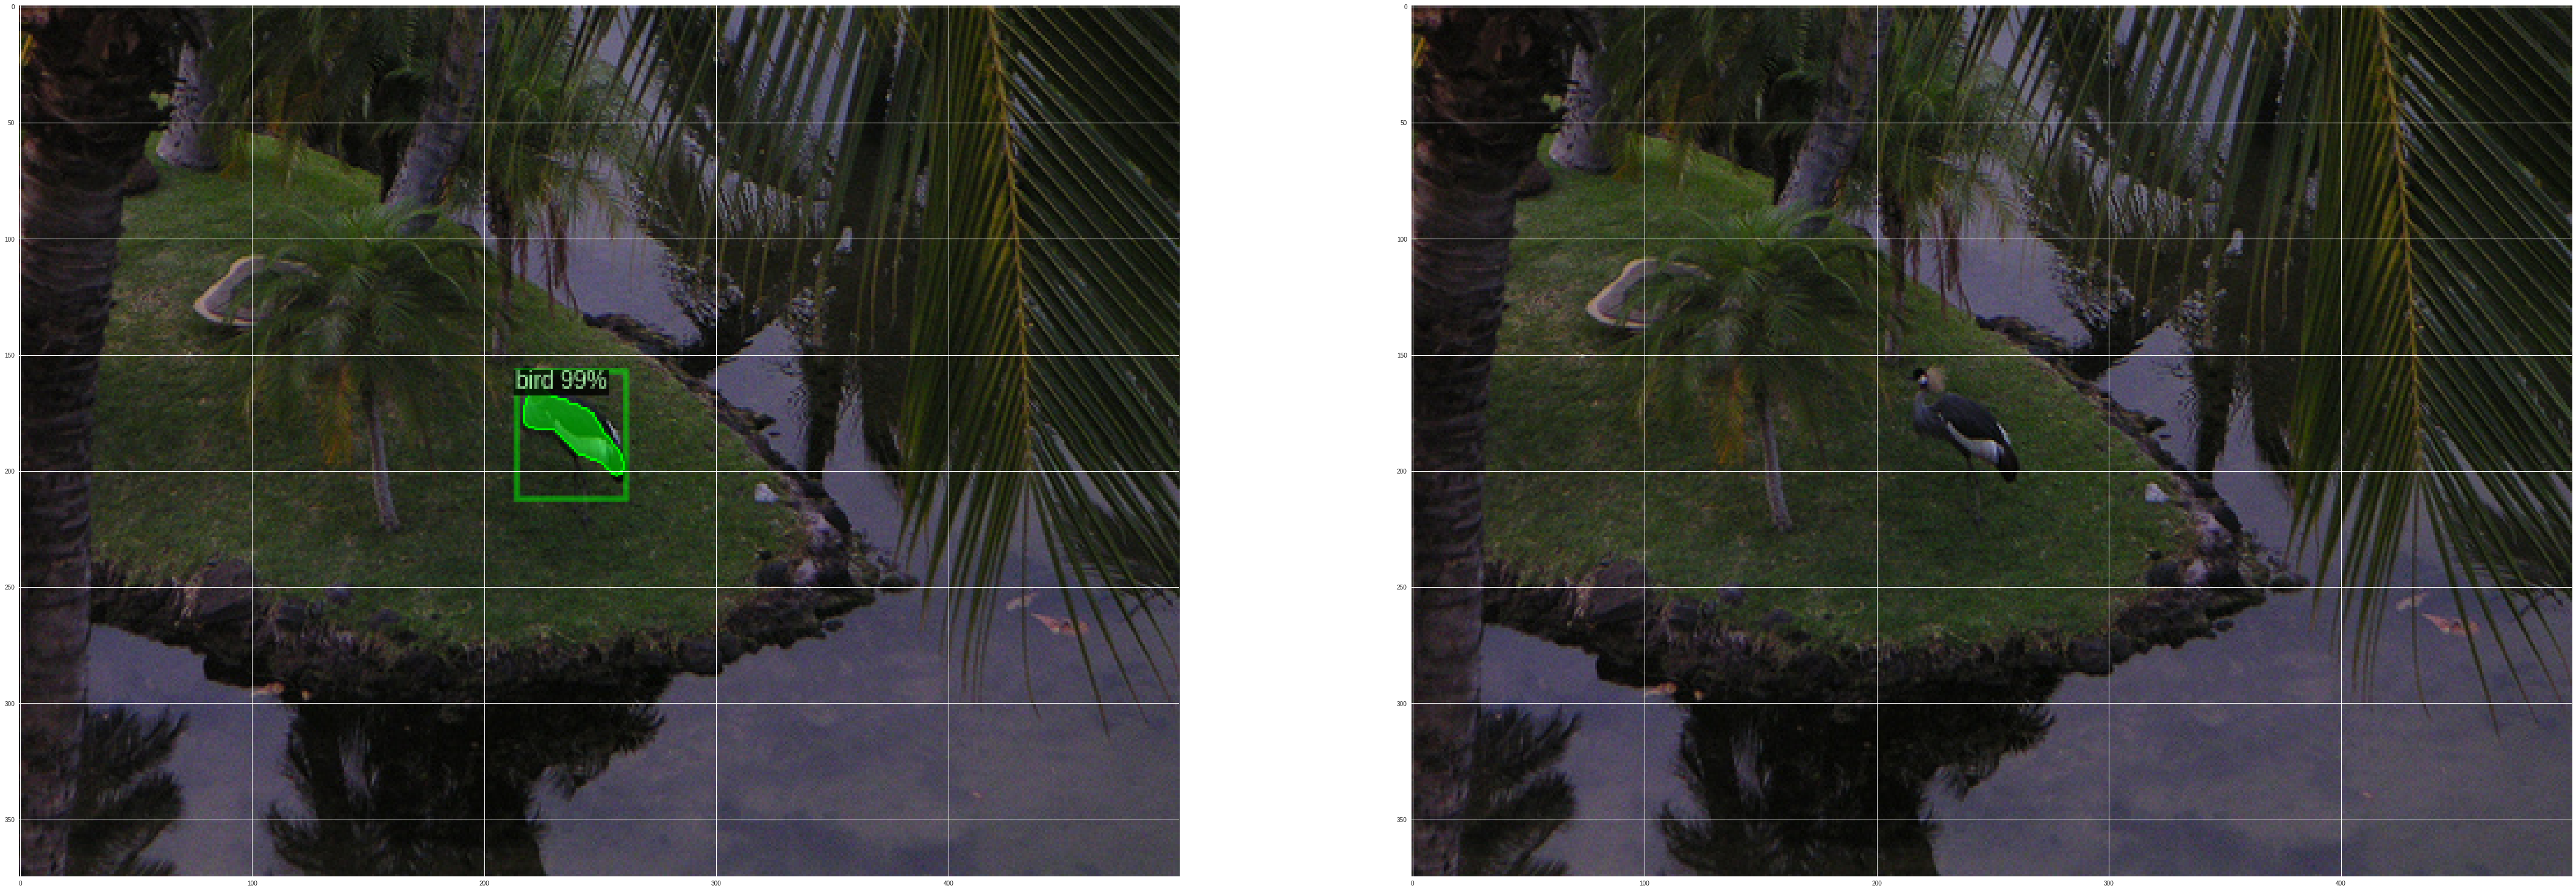



[test_images/2010_000238.jpg]: 



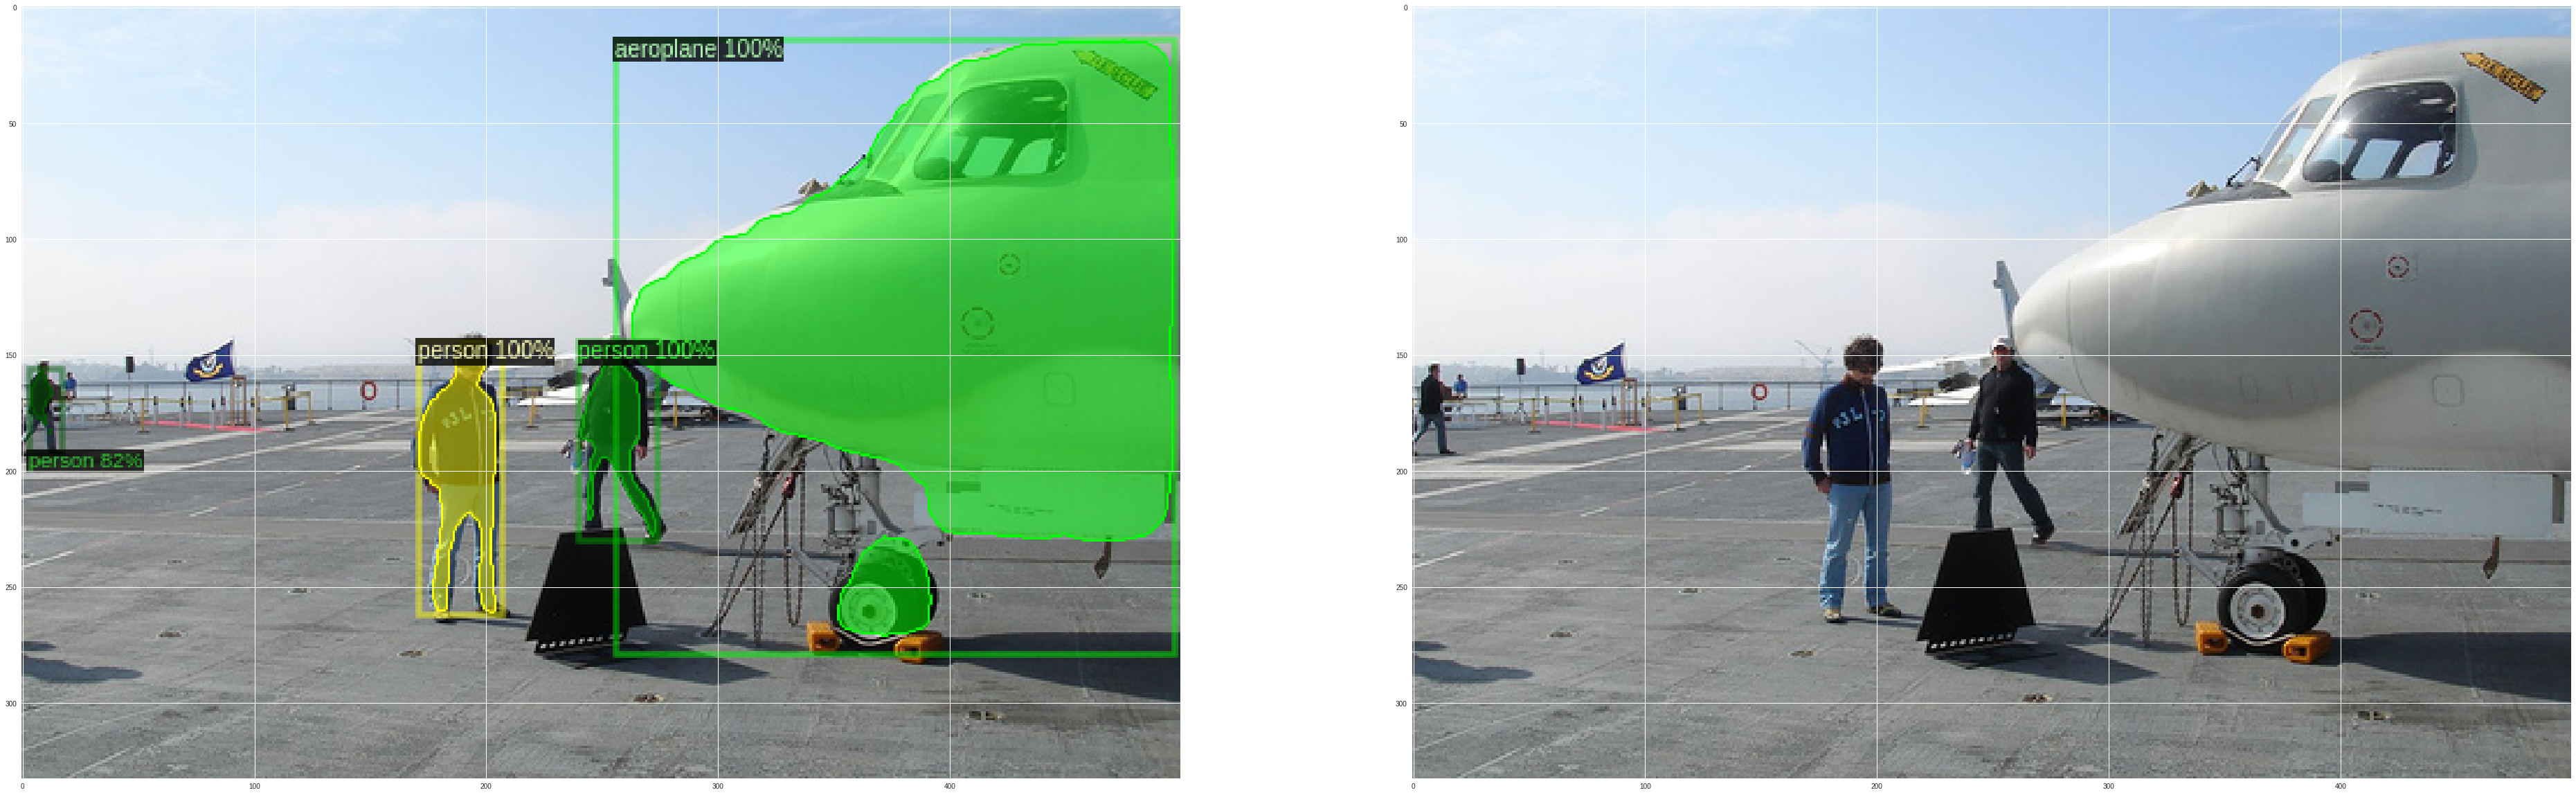



[test_images/2011_002575.jpg]: 



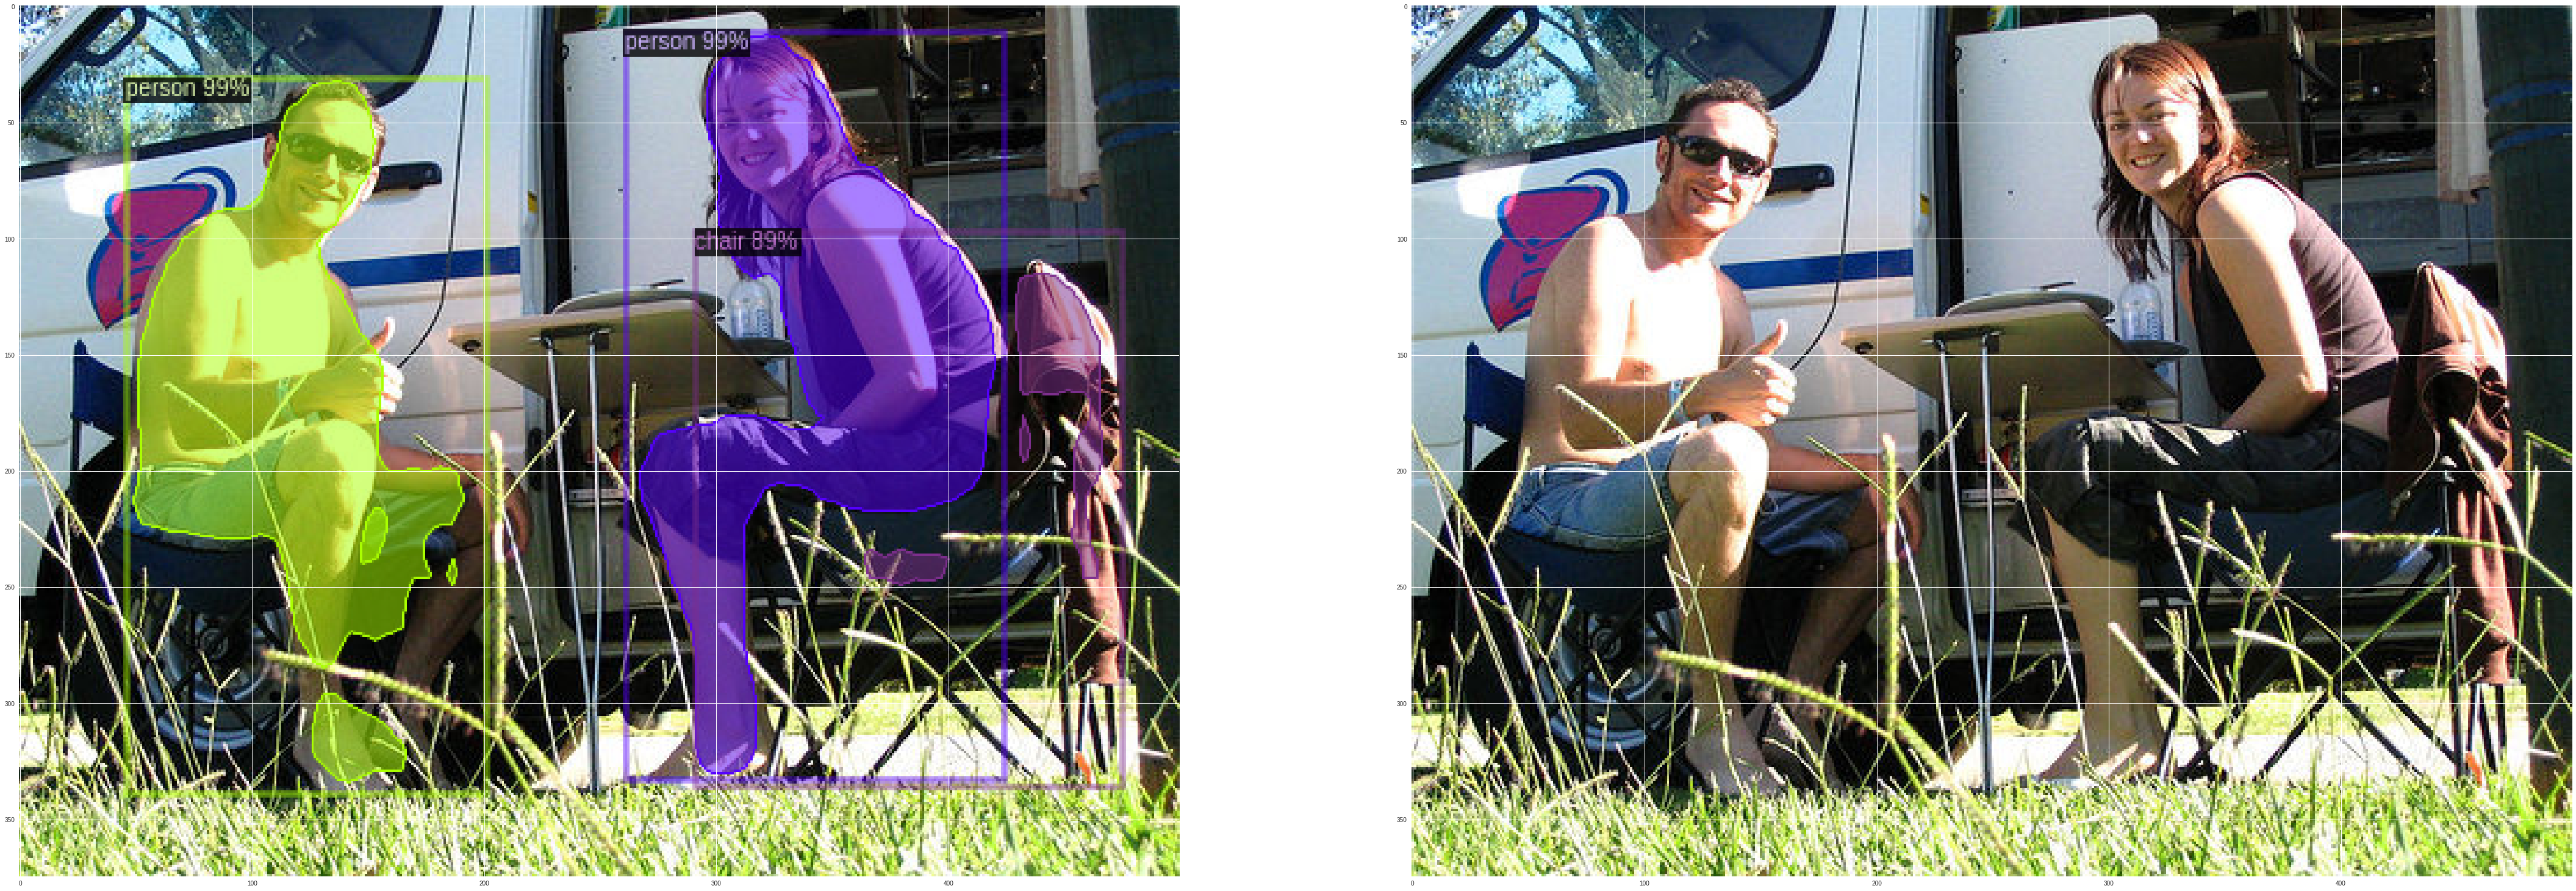

In [ ]:
ShowPredictImages(predictor, 5)

In [ ]:
res = DumpResultsToJSON(predictor, testPath)

Start predicting all images in [test_images]...


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()



Dumping the JSON file: [309612092.json] ...
Done!


In [ ]:
res

[{'category_id': 1,
  'image_id': 180,
  'score': 0.9845829010009766,
  'segmentation': {'counts': 'SP]13[:2N2O0000001O0000000000000001O0000000000010O0000001O000000001O0000000000001O00000000000000001O000000001O00001O0000000001O0O101O000001O00000000000O101OTW63hhI3M10OK5O1L4L4J7O10N2O10000O100000001O1O1O2N1O001O001O2N1O1O00001O0000000000000000000000000O100000000000000000000O1000000000000000000O10000000000000000O1000000000O10000000O10000000000000000000O1000O1000000000O10000000O10O10000000000000O10000O2NXX_1',
   'size': [335, 500]}},
 {'category_id': 1,
  'image_id': 180,
  'score': 0.9496950507164001,
  'segmentation': {'counts': 'Tgl26Y:1O1N2O00000O01O2O00001O00001N11O01NZdP2',
   'size': [335, 500]}},
 {'category_id': 15,
  'image_id': 92,
  'score': 0.9921063184738159,
  'segmentation': {'counts': '_;n0Y<c0A6K5K4N2N2N2N2N101N1O1O2N1O2M2O2M2O2M3N101N1O2O0O2N100O1O1O1O1O1N2N2O1O1O2O0O1O100O10000O1O100O1O1O1O1N2O1O1O1O100O100O100O1O100O1O1O1N2O1N2O1O100O1O100O1000000O10O10O10000O10000O1